In [66]:
import os

if not os.getcwd().endswith('Dissertation'):
    os.chdir('..')

In [67]:
import random

import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from src.ModelUsage import get_trained_model, convert_to_training_data, convert_to_input
from src.ModelUsage import random_search

def extension(csv_location: str, qualifying_session: str, event_date,
              wanted_drivers, tyres: str = 'Soft', train_to: int = -1,
              return_std: bool = False, return_con: bool = False,
              return_loss: bool = False, pbar: bool = True):

    data = pd.read_csv(csv_location)

    if train_to != -1:
        data = data[0:train_to]

    starting_lap = data.iloc[-1]['LapsCompleted'] + 1

    check_data = pd.read_csv(csv_location)
    check_data = check_data[:train_to]
    check_data = check_data[(check_data['Date'] == event_date) & (check_data['SessionName'] == qualifying_session)]

    lap_times_3_mins_to_go =  check_data.groupby('DriverName', group_keys=False).apply(lambda x: x[x['LapTime'] == x['LapTime'].min()]).sort_values('LapTime').reset_index(drop=True)
    lap_times_3_mins_to_go['LapsCompleted'] = starting_lap
    lap_times_3_mins_to_go['TyreUsage'] = 1
    lap_times_3_mins_to_go['TyreCompound'] = tyres

    cutoff = len(lap_times_3_mins_to_go) - 5

    dataframe = data.copy()
    indices = data.index[data['Date'] == event_date].tolist()

    X_kernel = random.sample(indices, len(indices) // 2)

    dataframe, X_kernel = dataframe.drop(index=X_kernel), dataframe.loc[X_kernel]

    X_train_kernel, y_train_kernel = convert_to_training_data(X_kernel)
    X_train, y_train = convert_to_training_data(dataframe)

    kernel = RBF() + RBF() + ConstantKernel()
    new_kernel, loss = random_search(GaussianProcessRegressor, kernel, (1e-10, 1e10),
                                     X_train, y_train, X_train_kernel, y_train_kernel,
                                     size=3, loops=10, return_loss=True, pbar=pbar)

    model, normalisation_constants = get_trained_model(new_kernel, csv_location,
                                                       data_cutoff=train_to,
                                                       return_constants=True)
    return_dict = dict()
    for wanted_driver in wanted_drivers:
        if wanted_driver not in lap_times_3_mins_to_go['DriverName'].unique():
            continue
        idx = lap_times_3_mins_to_go.index[lap_times_3_mins_to_go['DriverName'] == wanted_driver][0]
        to_knockout = cutoff - idx
        driver_lap_time = lap_times_3_mins_to_go.iloc[idx]['LapTime']
        if idx >= cutoff:
            return_dict[wanted_driver] =  0.0, 0.0, driver_lap_time
            continue

        input_to_model = convert_to_input(lap_times_3_mins_to_go[idx + 1:], normalisation_constants)
        means, stds = model.predict(input_to_model, return_std=True)
        means += lap_times_3_mins_to_go[idx + 1:]['ExpectedTime'].to_numpy()

        values = None
        samples = 100000
        for mean, std in zip(means, stds):
            sample= np.random.normal(mean, std, samples)
            if values is None:
                values = sample
            else:
                values = np.vstack((values, sample))
        faster = values < driver_lap_time
        sum_of_cols = np.sum(faster, axis=0)
        return_dict[wanted_driver] = 1 - np.sum(sum_of_cols >= to_knockout) / samples, np.std(sum_of_cols < to_knockout), driver_lap_time
    return return_dict

In [68]:
def get_driver_prob(folder, date, session, train_to):
    data = pd.read_csv(folder)
    data = data[(data['Date'] == date) & (data['SessionName'] == session)]
    drivers = data['DriverName'].unique().tolist()

    lap_times =  data.groupby('DriverName', group_keys=False).apply(lambda x: x[x['LapTime'] == x['LapTime'].min()]).sort_values('LapTime').reset_index(drop=True)['LapTime'].sort_values()

    cut_off = lap_times.iloc[len(lap_times)-5]
    driver_prob = extension(folder, session, date, drivers, train_to=train_to, pbar=False)
    return driver_prob, cut_off

In [69]:
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from glob import glob

def show_plot(lap_time, prob, std, session):
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)


    ax.errorbar(lap_time, prob, yerr=std, ls = "None", fmt="o", elinewidth=5, capsize=5, capthick=3, ecolor='black')
    ax.scatter(lap_time, prob, s = 100, marker = "h")
    cutoff_line = ax.axvline(x = cutoff[0], zorder=0, color='black', ls='--', lw=3)


    plt.title(f'Prob. of getting through to the next session based on your current lap time. ({session})', y=1.05)
    plt.ylabel('Prob. of getting through.', labelpad=15)
    plt.xlabel('Lap time set with 3 minutes until the end of the session.', labelpad=25)

    ax.legend((cutoff_line,), ('Actual cutoff time',))
    plt.savefig(f'data\\plots\\prob_proceeding_{session}.png')
    plt.show()

points = []
correct_mercedes, incorrect_mercedes = {'Lewis Hamilton': 0, 'Valtteri Bottas': 0}, {'Lewis Hamilton': 0, 'Valtteri Bottas': 0}
correct_model, incorrect_model = {'Lewis Hamilton': 0, 'Valtteri Bottas': 0}, {'Lewis Hamilton': 0, 'Valtteri Bottas': 0}
for year in [2019, 2020]:
    dates = [i.split('\\')[3].rstrip('.csv') for i in glob(f'Data\\test_csv\\{year}\\*.csv')]

    for date in tqdm(dates):
        for session in ['Q1', 'Q2']:


            folder = f'Data\\test_csv\\{year}\\{date}.csv'

            temp_data = pd.read_csv(folder)
            temp_data = temp_data[(temp_data['Date'] == date) & (temp_data['SessionName'] == session)]

            fastest_laps =  temp_data.groupby('DriverName', group_keys=False).apply(lambda x: x[x['LapTime'] == x['LapTime'].min()]).sort_values('LapTime').reset_index(drop=True)

            train_to = int([i for i in open(f'Data\\test_csv\\{year}\\train_to.txt').read().splitlines() if i.startswith(date)][0].split(' - ')[int(session[1])])


            driver_prob, cutoff = get_driver_prob(folder, date, session, train_to)

            for merc_driver in ['Lewis Hamilton', 'Valtteri Bottas']:
                if merc_driver not in driver_prob.keys():
                    continue

                idx = fastest_laps.index[fastest_laps['DriverName'] == merc_driver][0]
                driver_lap_time = fastest_laps.iloc[idx]['LapTime']

                again_mercedes = not (driver_prob[merc_driver][2] == driver_lap_time)
                again_model = driver_prob[merc_driver][0] < 0.99
                go_out_again = driver_prob[merc_driver][2] >= cutoff

                if go_out_again == again_model:
                    correct_model[merc_driver] += 1
                else:
                    incorrect_model[merc_driver] += 1
                if go_out_again == again_mercedes:
                    correct_mercedes[merc_driver] += 1
                else:
                    incorrect_mercedes[merc_driver] += 1




            unsorted_list = [(driver,) + vals for driver, vals in driver_prob.items()]

            sorted_list = sorted(unsorted_list, key=lambda x: x[3],)
            temp_points = [(i[1], i[2], i[3], cutoff) for i in sorted_list]
            points += [(i[1], i[3], cutoff) for i in sorted_list]
            prob, std, lap_time, cutoff = list(zip(*temp_points))

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [70]:
print(correct_model)
print(correct_mercedes)
print(incorrect_model)
print(incorrect_mercedes)

{'Lewis Hamilton': 24, 'Valtteri Bottas': 25}
{'Lewis Hamilton': 20, 'Valtteri Bottas': 18}
{'Lewis Hamilton': 1, 'Valtteri Bottas': 1}
{'Lewis Hamilton': 5, 'Valtteri Bottas': 8}


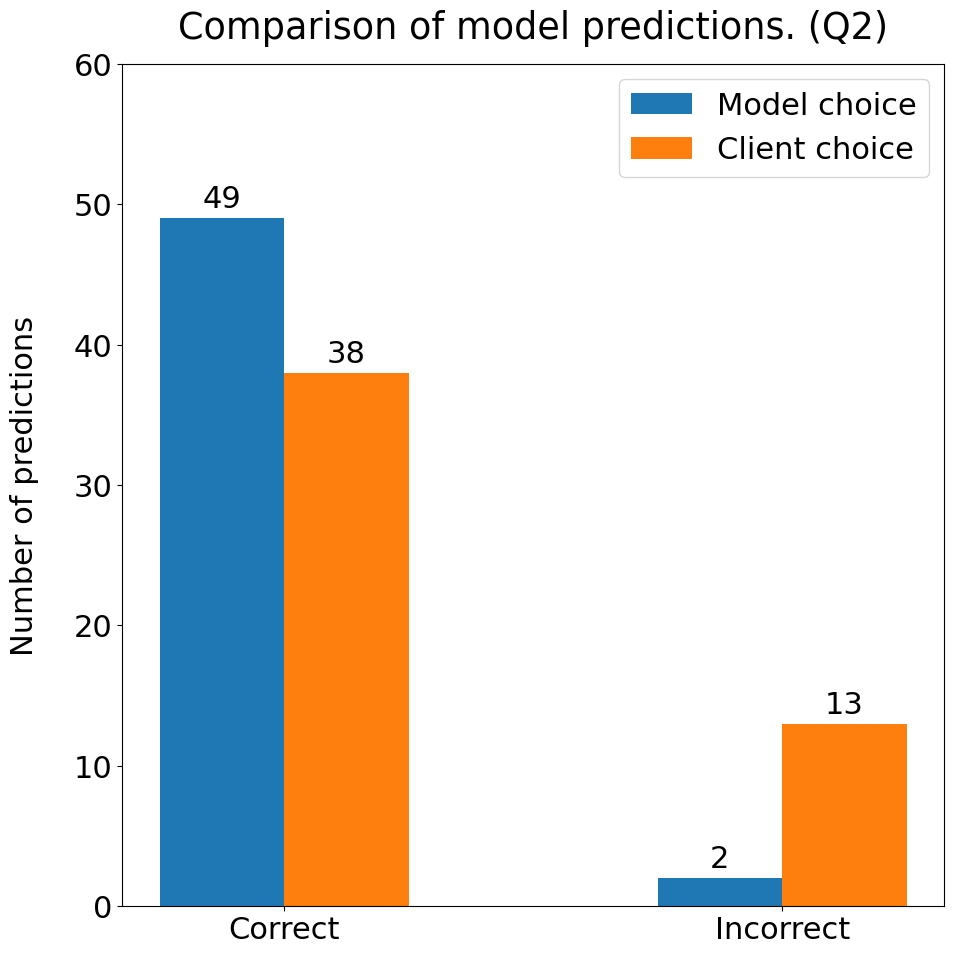

In [71]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
x = np.array([1, 1.4])
width = 0.1
model = [sum(correct_model.values()), sum(incorrect_model.values())]
mercedes = [sum(correct_mercedes.values()), sum(incorrect_mercedes.values())]
rects1 = ax.bar(x-(width/2), model, width=width, align='center', label='Model choice')
rects2 = ax.bar(x+(width/2), mercedes, width=width, align='center', label='Client choice')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2 , padding=3)

ax.legend()
ax.set_yticks([i*10 for i in range(7)])
ax.set_xticks(x)
ax.set_xticklabels([f'Correct', f'Incorrect'])

plt.title(f'Comparison of model predictions. (Q2)', y=1.02)
plt.ylabel('Number of predictions', labelpad=25)
plt.tight_layout()

plt.savefig(f'Data\\plots\\extension_comparison_Q2.png')

plt.show()



In [72]:
for limit in [0.7, 0.8, 0.9, 0.95, 0.99, 1]:
    true_positive = 0 # Stay in when safe
    true_negative = 0 # Go out when not safe
    false_positive = 0 # Stay in when not safe
    false_negative = 0 # Go out when safe
    for prob, lap_time, cutoff in points:
        if prob >= limit:
            if lap_time <= cutoff:
                true_positive += 1
            else:
                false_positive += 1
        else:
            if lap_time > cutoff:
                true_negative += 1
            else:
                false_negative += 1


    print(f'Using a limit of {limit}:')
    print(f'\tTrue positive: {true_positive}')
    print(f'\tTrue negative: {true_negative}')
    print(f'\tFalse positive: {false_positive}')
    print(f'\tFalse negative: {false_negative}')
    f1_score = (2*true_positive/(2*true_positive+false_positive+false_negative))
    print(f'\tF1-score: {f1_score}')
    print(f'\tF1-score * prob(false positive): {f1_score * (false_positive/(true_positive+true_negative+false_negative+false_positive))}')

Using a limit of 0.7:
	True positive: 169
	True negative: 152
	False positive: 11
	False negative: 36
	F1-score: 0.8779220779220779
	F1-score * prob(false positive): 0.02624223602484472
Using a limit of 0.8:
	True positive: 163
	True negative: 155
	False positive: 8
	False negative: 42
	F1-score: 0.8670212765957447
	F1-score * prob(false positive): 0.018848288621646624
Using a limit of 0.9:
	True positive: 157
	True negative: 155
	False positive: 8
	False negative: 48
	F1-score: 0.8486486486486486
	F1-score * prob(false positive): 0.01844888366627497
Using a limit of 0.95:
	True positive: 150
	True negative: 156
	False positive: 7
	False negative: 55
	F1-score: 0.8287292817679558
	F1-score * prob(false positive): 0.015763872207542638
Using a limit of 0.99:
	True positive: 132
	True negative: 157
	False positive: 6
	False negative: 73
	F1-score: 0.7696793002915452
	F1-score * prob(false positive): 0.012549119026492583
Using a limit of 1:
	True positive: 99
	True negative: 159
	False pos

In [73]:
12/ (337+376+12+147)

0.013761467889908258